In [27]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import datetime


%matplotlib inline
from RL_env.config import config
from RL_env.marketdata.yahoodownloader import YahooDownloader
from RL_env.preprocessing.preprocessors import FeatureEngineer
from RL_env.preprocessing.data import data_split
from RL_env.env.env_stocktrading import StockTradingEnv
from RL_env.model.models import DRLAgent,DRLEnsembleAgent
from RL_env.trade.backtest import backtest_stats, get_baseline, backtest_plot
from RL_env.trade.backtest import convert_daily_return_to_pyfolio_ts,get_daily_return


from pprint import pprint
from pyfolio import timeseries

import sys
sys.path.append("../FinRL-Library")

import itertools

In [28]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [29]:
start_date=config.START_DATE
end_date=config.END_DATE

In [30]:
df = YahooDownloader(start_date = start_date,
                     end_date = end_date,
                     ticker_list = config.PRO2_10_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (52840, 8)


In [31]:
# df.to_csv('susa.csv')

In [32]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2000-01-03,10.96875,11.0000,10.640625,8.773580,1046800,EXPD,0
1,2000-01-03,38.00000,38.0625,35.375000,35.375000,51400,MTD,0
2,2000-01-03,17.50000,17.5000,17.031250,6.980553,5351200,PEG,0
3,2000-01-03,35.37500,37.3750,35.000000,21.812716,5298400,PEP,0
4,2000-01-03,31.31250,31.3125,29.812500,17.481575,1100000,PPG,0


In [33]:
df.tail(10)

,date,open,high,low,close,volume,tic,day
52830,2020-12-31,94.480003,95.169998,94.099998,94.668900,468900,EXPD,3
52831,2020-12-31,1138.609985,1140.680054,1127.349976,1139.680054,110800,MTD,3
52832,2020-12-31,57.279999,58.340000,57.189999,57.771507,1860400,PEG,3
52833,2020-12-31,147.479996,148.460007,146.639999,146.058167,2076800,PEP,3
52834,2020-12-31,143.039993,144.440002,141.929993,143.219147,930000,PPG,3
52835,2020-12-31,324.299988,328.850006,323.309998,327.304321,1014200,SPGI,3
52836,2020-12-31,143.220001,143.220001,140.449997,139.758423,713700,TSCO,3
52837,2020-12-31,48.419998,49.080002,47.799999,48.636711,1701400,VTR,3
52838,2020-12-31,58.060001,58.799999,58.020000,57.509003,12906300,VZ,3
52839,2020-12-31,383.720001,385.489990,380.459991,384.329987,176500,ZBRA,3


In [34]:
df.shape

(52840, 8)

In [35]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    use_turbulence=False,
                    user_defined_feature = True)

df = fe.preprocess_data(df)

Successfully added technical indicators
Successfully added user defined features


In [36]:
df.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,daily_return,log_return,return_lag_4
0,2000-01-03,10.96875,11.0000,10.640625,8.773580,1046800,EXPD,0,0.0,8.907065,8.494083,0.0,-66.666667,100.0,8.773580,8.773580,3.031992,1.394260,1.20808
5284,2000-01-03,38.00000,38.0625,35.375000,35.375000,51400,MTD,0,0.0,8.907065,8.494083,0.0,-66.666667,100.0,35.375000,35.375000,3.031992,1.394260,1.20808
10568,2000-01-03,17.50000,17.5000,17.031250,6.980553,5351200,PEG,0,0.0,8.907065,8.494083,0.0,-66.666667,100.0,6.980553,6.980553,-0.802670,-1.622877,1.20808
15852,2000-01-03,35.37500,37.3750,35.000000,21.812716,5298400,PEP,0,0.0,8.907065,8.494083,0.0,-66.666667,100.0,21.812716,21.812716,2.124783,1.139365,1.20808
21136,2000-01-03,31.31250,31.3125,29.812500,17.481575,1100000,PPG,0,0.0,8.907065,8.494083,0.0,-66.666667,100.0,17.481575,17.481575,-0.198560,-0.221346,1.20808


In [37]:
# add covariance matrix as states
df=df.sort_values(['date','tic'],ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
# look back is one year
lookback=252
for i in range(lookback,len(df.index.unique())):
    data_lookback = df.loc[i-lookback:i,:]
    price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
    return_lookback = price_lookback.pct_change().dropna()
    covs = return_lookback.cov().values 
    cov_list.append(covs)

df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date','tic']).reset_index(drop=True)

In [38]:
df.shape

(50320, 20)

In [39]:
df.head(10)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,daily_return,log_return,return_lag_4,cov_list
0,2001-01-02,13.644531,13.687500,12.250000,10.111978,2412800,EXPD,1,-0.117368,11.588668,9.216021,48.425627,-35.283020,2.154183,10.718556,10.347309,-0.442311,-0.583955,-0.488824,"[[0.0014069613989072562, 0.0003008195909515592..."
1,2001-01-02,53.625000,53.687500,51.250000,52.000000,134100,MTD,1,1.427017,54.874902,43.787598,55.906578,135.259209,23.842806,49.045833,47.737500,4.142416,1.637523,109.938383,"[[0.0014069613989072562, 0.0003008195909515592..."
2,2001-01-02,24.250000,24.250000,23.312500,10.184226,1143600,PEG,1,0.388193,11.104872,9.150192,59.783849,72.402367,18.511712,9.730554,9.304631,-0.804149,-1.630404,3.639313,"[[0.0014069613989072562, 0.0003008195909515592..."
3,2001-01-02,49.375000,49.500000,48.750000,29.627275,4267800,PEP,1,0.507075,30.895525,26.650910,56.139662,84.734799,1.446040,28.100735,28.193380,1.909134,1.067855,0.673019,"[[0.0014069613989072562, 0.0003008195909515592..."
4,2001-01-02,23.375000,23.437500,22.625000,13.686797,2276600,PPG,1,0.286361,14.308746,12.144243,55.104922,140.866507,24.308745,13.024739,12.738814,-0.538034,-0.772264,-0.245156,"[[0.0014069613989072562, 0.0003008195909515592..."
5,2001-01-02,29.250000,29.250000,28.187500,19.149103,593000,SPGI,1,0.036161,20.015698,17.862836,48.125619,65.173392,15.059239,18.802057,19.651690,0.399093,0.335824,0.893705,"[[0.0014069613989072562, 0.0003008195909515592..."
6,2001-01-02,0.531250,0.546875,0.531250,0.472175,686400,TSCO,1,0.001400,0.472247,0.399037,48.162894,214.501949,35.809840,0.430759,0.468528,-0.975342,-3.702662,-0.990920,"[[0.0014069613989072562, 0.0003008195909515592..."
7,2001-01-02,6.352061,6.780290,6.352061,2.292767,228120,VTR,1,0.092696,2.225830,1.764660,66.063306,152.666251,21.668769,1.890896,1.846461,3.855757,1.580165,-0.774871,"[[0.0014069613989072562, 0.0003008195909515592..."
8,2001-01-02,44.628891,45.415798,43.898193,17.753023,5242945,VZ,1,-0.478498,21.532499,16.342828,46.903741,-94.968453,30.269895,18.973361,18.688518,6.743057,2.046797,-0.400788,"[[0.0014069613989072562, 0.0003008195909515592..."
9,2001-01-02,18.277779,19.000000,18.166668,18.833332,576000,ZBRA,1,-0.328538,19.601629,16.758788,48.869298,-22.267185,3.398072,19.046065,19.070486,0.060852,0.059072,0.376022,"[[0.0014069613989072562, 0.0003008195909515592..."


In [40]:
train = data_split(df, config.START_DATE,'2019-01-01')
trade = data_split(df, '2019-01-02', config.END_DATE)

In [41]:
train.head(10)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,daily_return,log_return,return_lag_4,cov_list
0,2001-01-02,13.644531,13.687500,12.250000,10.111978,2412800,EXPD,1,-0.117368,11.588668,9.216021,48.425627,-35.283020,2.154183,10.718556,10.347309,-0.442311,-0.583955,-0.488824,"[[0.0014069613989072562, 0.0003008195909515592..."
0,2001-01-02,53.625000,53.687500,51.250000,52.000000,134100,MTD,1,1.427017,54.874902,43.787598,55.906578,135.259209,23.842806,49.045833,47.737500,4.142416,1.637523,109.938383,"[[0.0014069613989072562, 0.0003008195909515592..."
0,2001-01-02,24.250000,24.250000,23.312500,10.184226,1143600,PEG,1,0.388193,11.104872,9.150192,59.783849,72.402367,18.511712,9.730554,9.304631,-0.804149,-1.630404,3.639313,"[[0.0014069613989072562, 0.0003008195909515592..."
0,2001-01-02,49.375000,49.500000,48.750000,29.627275,4267800,PEP,1,0.507075,30.895525,26.650910,56.139662,84.734799,1.446040,28.100735,28.193380,1.909134,1.067855,0.673019,"[[0.0014069613989072562, 0.0003008195909515592..."
0,2001-01-02,23.375000,23.437500,22.625000,13.686797,2276600,PPG,1,0.286361,14.308746,12.144243,55.104922,140.866507,24.308745,13.024739,12.738814,-0.538034,-0.772264,-0.245156,"[[0.0014069613989072562, 0.0003008195909515592..."
0,2001-01-02,29.250000,29.250000,28.187500,19.149103,593000,SPGI,1,0.036161,20.015698,17.862836,48.125619,65.173392,15.059239,18.802057,19.651690,0.399093,0.335824,0.893705,"[[0.0014069613989072562, 0.0003008195909515592..."
0,2001-01-02,0.531250,0.546875,0.531250,0.472175,686400,TSCO,1,0.001400,0.472247,0.399037,48.162894,214.501949,35.809840,0.430759,0.468528,-0.975342,-3.702662,-0.990920,"[[0.0014069613989072562, 0.0003008195909515592..."
0,2001-01-02,6.352061,6.780290,6.352061,2.292767,228120,VTR,1,0.092696,2.225830,1.764660,66.063306,152.666251,21.668769,1.890896,1.846461,3.855757,1.580165,-0.774871,"[[0.0014069613989072562, 0.0003008195909515592..."
0,2001-01-02,44.628891,45.415798,43.898193,17.753023,5242945,VZ,1,-0.478498,21.532499,16.342828,46.903741,-94.968453,30.269895,18.973361,18.688518,6.743057,2.046797,-0.400788,"[[0.0014069613989072562, 0.0003008195909515592..."
0,2001-01-02,18.277779,19.000000,18.166668,18.833332,576000,ZBRA,1,-0.328538,19.601629,16.758788,48.869298,-22.267185,3.398072,19.046065,19.070486,0.060852,0.059072,0.376022,"[[0.0014069613989072562, 0.0003008195909515592..."


In [42]:
train.tail(10)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,daily_return,log_return,return_lag_4,cov_list
4526,2018-12-31,66.940002,68.120003,66.730003,66.000504,1278300,EXPD,0,-1.504801,75.186821,60.188368,46.490866,-79.877301,12.387221,68.940178,67.674491,-0.576838,-0.860001,-0.598910,"[[0.0002453241227720635, 0.0001393384709219195..."
4526,2018-12-31,561.419983,567.150024,558.340027,565.580017,89800,MTD,0,-10.812117,646.462011,520.594001,46.919350,-78.474674,11.930359,589.180337,579.072836,7.569329,2.148189,6.018163,"[[0.0002453241227720635, 0.0001393384709219195..."
4526,2018-12-31,51.299999,52.099998,50.919998,48.198940,2847100,PEG,0,-0.678488,53.429137,46.120934,46.023880,-109.940757,27.003868,49.735555,49.615395,-0.914780,-2.462515,-0.075144,"[[0.0002453241227720635, 0.0001393384709219195..."
4526,2018-12-31,110.580002,111.089996,109.320000,102.682220,5019100,PEP,0,-1.453373,113.166471,97.842704,46.860836,-96.802042,12.408936,106.295728,104.380512,1.130383,0.756302,1.064777,"[[0.0002453241227720635, 0.0001393384709219195..."
4526,2018-12-31,101.820000,102.910004,101.230003,97.968750,1162700,PPG,0,-1.411328,105.603504,88.938670,48.225985,-24.219159,3.500091,99.065055,98.798357,-0.045903,-0.046990,-0.371874,"[[0.0002453241227720635, 0.0001393384709219195..."
4526,2018-12-31,169.119995,170.720001,168.410004,166.156204,944800,SPGI,0,-3.127977,177.997572,153.384993,44.355822,-32.062725,7.490643,168.540599,173.941700,0.696012,0.528280,1.517499,"[[0.0002453241227720635, 0.0001393384709219195..."
4526,2018-12-31,83.580002,83.910004,82.809998,80.810799,1044100,TSCO,0,-2.383776,94.430477,75.327372,44.065851,-105.354728,21.783208,86.029496,86.682886,-0.513646,-0.720818,-0.857119,"[[0.0002453241227720635, 0.0001393384709219195..."
4526,2018-12-31,58.730000,58.950001,57.700001,52.135563,1739200,VTR,0,-0.447188,58.441380,50.343024,48.761658,-150.053730,35.094131,54.311528,52.012421,-0.354844,-0.438263,0.081674,"[[0.0002453241227720635, 0.0001393384709219195..."
4526,2018-12-31,55.529999,56.230000,55.070000,50.585201,15331800,VZ,0,-0.720371,54.110994,47.781927,49.637835,-70.498519,14.948583,51.854781,51.142939,-0.029737,-0.030188,-0.507362,"[[0.0002453241227720635, 0.0001393384709219195..."
4526,2018-12-31,157.070007,159.330002,155.979996,159.229996,409100,ZBRA,0,-4.679956,185.164031,141.864967,47.288334,-69.146499,15.592075,166.152999,166.279332,2.147758,1.146691,0.625314,"[[0.0002453241227720635, 0.0001393384709219195..."


In [43]:
trade.head(10)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,daily_return,log_return,return_lag_4,cov_list
0,2019-01-02,66.769997,67.900002,66.379997,65.244446,1121300,EXPD,2,-1.420727,74.260809,60.263324,45.351676,-82.644087,14.534151,68.751051,67.590205,-0.590250,-0.892209,-0.607331,"[[0.00024543144167401957, 0.000140750497413382..."
0,2019-01-02,557.479980,559.880005,543.520020,546.039978,212200,MTD,2,-11.577475,638.794946,519.199067,43.683289,-110.365920,21.698880,587.633669,577.979003,7.369141,2.124551,5.757017,"[[0.00024543144167401957, 0.000140750497413382..."
0,2019-01-02,51.799999,51.799999,50.520000,47.069214,3355900,PEG,2,-0.742562,53.326950,45.795370,42.484773,-127.105074,30.189400,49.638286,49.599216,-0.913799,-2.451073,-0.097176,"[[0.00024543144167401957, 0.000140750497413382..."
0,2019-01-02,109.150002,110.019997,108.230003,101.566902,4835400,PEP,2,-1.470542,112.074011,97.847801,45.284944,-109.113257,17.587192,106.091259,104.434881,1.157820,0.769099,1.007838,"[[0.00024543144167401957, 0.000140750497413382..."
0,2019-01-02,101.029999,102.199997,100.449997,97.451241,1063300,PPG,2,-1.191479,104.456447,89.353571,47.526820,-33.658624,0.948543,98.892877,98.697819,-0.040522,-0.041366,-0.387984,"[[0.00024543144167401957, 0.000140750497413382..."
0,2019-01-02,169.270004,171.270004,167.000000,166.068222,1362200,SPGI,2,-2.720375,175.716328,154.394207,44.299937,-32.795315,11.427822,168.190583,173.573485,0.704116,0.533047,1.545324,"[[0.00024543144167401957, 0.000140750497413382..."
0,2019-01-02,81.809998,84.010002,80.860001,79.638908,1517100,TSCO,2,-2.392020,93.435384,75.073114,42.764379,-113.182372,29.240777,85.682614,86.601936,-0.520445,-0.734896,-0.854152,"[[0.00024543144167401957, 0.000140750497413382..."
0,2019-01-02,58.020000,58.139999,56.520000,50.649532,1794400,VTR,2,-0.599552,58.460695,49.814560,44.903835,-192.796950,42.484938,54.231363,52.082668,-0.364010,-0.452573,0.076065,"[[0.00024543144167401957, 0.000140750497413382..."
0,2019-01-02,56.160000,56.160000,55.279999,50.405243,13969700,VZ,2,-0.644827,53.513176,47.994642,49.101411,-65.995075,14.948583,51.763004,51.166977,-0.004823,-0.004835,-0.503724,"[[0.00024543144167401957, 0.000140750497413382..."
0,2019-01-02,155.990005,157.460007,152.270004,156.240005,347700,ZBRA,2,-4.446819,182.785576,141.887422,46.029026,-86.213500,21.459145,165.397332,166.129999,2.099678,1.131298,0.603263,"[[0.00024543144167401957, 0.000140750497413382..."


In [44]:
trade.tail(10)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,daily_return,log_return,return_lag_4,cov_list
504,2020-12-31,94.480003,95.169998,94.099998,94.668900,468900,EXPD,3,1.460399,96.829452,87.147328,59.907496,106.922102,34.494764,90.917391,90.424400,-0.753306,-1.399606,-0.706204,"[[0.00041196354653177025, 0.000311918088435705..."
504,2020-12-31,1138.609985,1140.680054,1127.349976,1139.680054,110800,MTD,3,3.428232,1159.288879,1114.298108,55.827684,-22.156841,2.610898,1138.099333,1104.286831,11.038590,2.488117,7.030119,"[[0.00041196354653177025, 0.000311918088435705..."
504,2020-12-31,57.279999,58.340000,57.189999,57.771507,1860400,PEG,3,-0.067901,57.442969,55.525656,54.550250,50.491075,4.636450,56.799586,57.487044,-0.949309,-2.982007,0.203275,"[[0.00041196354653177025, 0.000311918088435705..."
504,2020-12-31,147.479996,148.460007,146.639999,146.058167,2076800,PEP,3,1.254220,145.743402,141.042728,61.115992,196.894681,36.704361,142.563068,139.597788,1.528204,0.927509,1.566391,"[[0.00041196354653177025, 0.000311918088435705..."
504,2020-12-31,143.039993,144.440002,141.929993,143.219147,930000,PPG,3,0.466079,145.813420,140.730130,55.872296,-62.045510,1.155041,143.817960,139.074662,-0.019438,-0.019629,-0.626790,"[[0.00041196354653177025, 0.000311918088435705..."
504,2020-12-31,324.299988,328.850006,323.309998,327.304321,1014200,SPGI,3,-3.714645,335.799567,310.036267,47.999502,-18.527978,2.500436,327.490699,333.881650,1.285339,0.826514,2.457358,"[[0.00041196354653177025, 0.000311918088435705..."
504,2020-12-31,143.220001,143.220001,140.449997,139.758423,713700,TSCO,3,1.853094,150.556303,131.135735,50.673351,29.504620,1.832962,138.534892,138.740911,-0.573002,-0.850975,-0.877370,"[[0.00041196354653177025, 0.000311918088435705..."
504,2020-12-31,48.419998,49.080002,47.799999,48.636711,1701400,VTR,3,0.470189,50.150636,46.908443,55.363863,-42.644192,2.963657,48.252830,45.574378,-0.651994,-1.055537,-0.158119,"[[0.00041196354653177025, 0.000311918088435705..."
504,2020-12-31,58.060001,58.799999,58.020000,57.509003,12906300,VZ,3,-0.405310,60.927017,56.565592,46.770789,-155.678783,18.422305,58.897704,58.124588,0.182420,0.167563,-0.606260,"[[0.00041196354653177025, 0.000311918088435705..."
504,2020-12-31,383.720001,385.489990,380.459991,384.329987,176500,ZBRA,3,7.802211,385.613850,370.790148,63.571885,100.329410,16.995806,373.956333,341.365499,5.682953,1.899560,1.683510,"[[0.00041196354653177025, 0.000311918088435705..."


In [45]:
from RL_env.env.env_portfolio import StockPortfolioEnv

In [46]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 10, State Space: 10


In [47]:
train.tic.unique()

array(['EXPD', 'MTD', 'PEG', 'PEP', 'PPG', 'SPGI', 'TSCO', 'VTR', 'VZ',
       'ZBRA'], dtype=object)

In [48]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 100000, 
    "transaction_cost_pct": 0.0025, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "turbulence_threshold":330
}

e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)


In [49]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [50]:
# initialize
agent = DRLAgent(env = env_train)

In [51]:
agent = DRLAgent(env = env_train)
A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}
Using cpu device


In [52]:
trained_a2c = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c',
                                total_timesteps=500000)

Logging to tensorboard_log/a2c\a2c_18
------------------------------------
| time/                 |          |
|    fps                | 369      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -14.2    |
|    explained_variance | 6.56e-06 |
|    learning_rate      | 0.0002   |
|    n_updates          | 99       |
|    policy_loss        | 6.16e+06 |
|    std                | 0.999    |
|    value_loss         | 2.48e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 392       |
|    iterations         | 200       |
|    time_elapsed       | 2         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -14.2     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 1

------------------------------------
| time/                 |          |
|    fps                | 475      |
|    iterations         | 1500     |
|    time_elapsed       | 15       |
|    total_timesteps    | 7500     |
| train/                |          |
|    entropy_loss       | -14.1    |
|    explained_variance | 2.38e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 1499     |
|    policy_loss        | 2.48e+07 |
|    std                | 0.994    |
|    value_loss         | 3.38e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 476      |
|    iterations         | 1600     |
|    time_elapsed       | 16       |
|    total_timesteps    | 8000     |
| train/                |          |
|    entropy_loss       | -14.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 1599     |
|    policy_loss        | 3.49e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 482      |
|    iterations         | 2900     |
|    time_elapsed       | 30       |
|    total_timesteps    | 14500    |
| train/                |          |
|    entropy_loss       | -14      |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 2899     |
|    policy_loss        | 9.25e+06 |
|    std                | 0.982    |
|    value_loss         | 5.07e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 482      |
|    iterations         | 3000     |
|    time_elapsed       | 31       |
|    total_timesteps    | 15000    |
| train/                |          |
|    entropy_loss       | -14      |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 2999     |
|    policy_loss        | 1.23e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 485      |
|    iterations         | 4300     |
|    time_elapsed       | 44       |
|    total_timesteps    | 21500    |
| train/                |          |
|    entropy_loss       | -14      |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 4299     |
|    policy_loss        | 3.45e+07 |
|    std                | 0.979    |
|    value_loss         | 8.03e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 485      |
|    iterations         | 4400     |
|    time_elapsed       | 45       |
|    total_timesteps    | 22000    |
| train/                |          |
|    entropy_loss       | -14      |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 4399     |
|    policy_loss        | 4.36e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 486      |
|    iterations         | 5600     |
|    time_elapsed       | 57       |
|    total_timesteps    | 28000    |
| train/                |          |
|    entropy_loss       | -13.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 5599     |
|    policy_loss        | 8.62e+06 |
|    std                | 0.972    |
|    value_loss         | 4.78e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 486      |
|    iterations         | 5700     |
|    time_elapsed       | 58       |
|    total_timesteps    | 28500    |
| train/                |          |
|    entropy_loss       | -13.9    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 5699     |
|    policy_loss        | 1.38e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 487      |
|    iterations         | 7000     |
|    time_elapsed       | 71       |
|    total_timesteps    | 35000    |
| train/                |          |
|    entropy_loss       | -13.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 6999     |
|    policy_loss        | 3.05e+07 |
|    std                | 0.966    |
|    value_loss         | 7.24e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 487      |
|    iterations         | 7100     |
|    time_elapsed       | 72       |
|    total_timesteps    | 35500    |
| train/                |          |
|    entropy_loss       | -13.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 7099     |
|    policy_loss        | 4e+07    |
|

------------------------------------
| time/                 |          |
|    fps                | 487      |
|    iterations         | 8300     |
|    time_elapsed       | 85       |
|    total_timesteps    | 41500    |
| train/                |          |
|    entropy_loss       | -13.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 8299     |
|    policy_loss        | 7.25e+06 |
|    std                | 0.955    |
|    value_loss         | 3.63e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 487       |
|    iterations         | 8400      |
|    time_elapsed       | 86        |
|    total_timesteps    | 42000     |
| train/                |           |
|    entropy_loss       | -13.7     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 8399      |
|    policy_loss        | 8

------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 9700     |
|    time_elapsed       | 99       |
|    total_timesteps    | 48500    |
| train/                |          |
|    entropy_loss       | -13.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 9699     |
|    policy_loss        | 2.99e+07 |
|    std                | 0.946    |
|    value_loss         | 6.73e+12 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 488       |
|    iterations         | 9800      |
|    time_elapsed       | 100       |
|    total_timesteps    | 49000     |
| train/                |           |
|    entropy_loss       | -13.6     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 9799      |
|    policy_loss        | 3

------------------------------------
| time/                 |          |
|    fps                | 487      |
|    iterations         | 11000    |
|    time_elapsed       | 112      |
|    total_timesteps    | 55000    |
| train/                |          |
|    entropy_loss       | -13.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 10999    |
|    policy_loss        | 7.07e+06 |
|    std                | 0.937    |
|    value_loss         | 3.61e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 487      |
|    iterations         | 11100    |
|    time_elapsed       | 113      |
|    total_timesteps    | 55500    |
| train/                |          |
|    entropy_loss       | -13.5    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 11099    |
|    policy_loss        | 1.04e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 12400    |
|    time_elapsed       | 126      |
|    total_timesteps    | 62000    |
| train/                |          |
|    entropy_loss       | -13.4    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 12399    |
|    policy_loss        | 2.69e+07 |
|    std                | 0.928    |
|    value_loss         | 4.7e+12  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 12500    |
|    time_elapsed       | 127      |
|    total_timesteps    | 62500    |
| train/                |          |
|    entropy_loss       | -13.4    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 12499    |
|    policy_loss        | 3.55e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 13700    |
|    time_elapsed       | 140      |
|    total_timesteps    | 68500    |
| train/                |          |
|    entropy_loss       | -13.4    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 13699    |
|    policy_loss        | 5.86e+06 |
|    std                | 0.921    |
|    value_loss         | 2.24e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 488       |
|    iterations         | 13800     |
|    time_elapsed       | 141       |
|    total_timesteps    | 69000     |
| train/                |           |
|    entropy_loss       | -13.4     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 13799     |
|    policy_loss        | 1

------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 15100    |
|    time_elapsed       | 154      |
|    total_timesteps    | 75500    |
| train/                |          |
|    entropy_loss       | -13.3    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 15099    |
|    policy_loss        | 2.52e+07 |
|    std                | 0.913    |
|    value_loss         | 4.83e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 15200    |
|    time_elapsed       | 155      |
|    total_timesteps    | 76000    |
| train/                |          |
|    entropy_loss       | -13.3    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 15199    |
|    policy_loss        | 3.71e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 16400    |
|    time_elapsed       | 167      |
|    total_timesteps    | 82000    |
| train/                |          |
|    entropy_loss       | -13.2    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 16399    |
|    policy_loss        | 5.89e+06 |
|    std                | 0.905    |
|    value_loss         | 2.23e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 488       |
|    iterations         | 16500     |
|    time_elapsed       | 168       |
|    total_timesteps    | 82500     |
| train/                |           |
|    entropy_loss       | -13.2     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 16499     |
|    policy_loss        | 1

------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 17800    |
|    time_elapsed       | 182      |
|    total_timesteps    | 89000    |
| train/                |          |
|    entropy_loss       | -13.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 17799    |
|    policy_loss        | 2.4e+07  |
|    std                | 0.899    |
|    value_loss         | 3.75e+12 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 488       |
|    iterations         | 17900     |
|    time_elapsed       | 183       |
|    total_timesteps    | 89500     |
| train/                |           |
|    entropy_loss       | -13.1     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 17899     |
|    policy_loss        | 3

------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 19200    |
|    time_elapsed       | 196      |
|    total_timesteps    | 96000    |
| train/                |          |
|    entropy_loss       | -13.1    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 19199    |
|    policy_loss        | 9.46e+06 |
|    std                | 0.894    |
|    value_loss         | 6.76e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 19300    |
|    time_elapsed       | 197      |
|    total_timesteps    | 96500    |
| train/                |          |
|    entropy_loss       | -13.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 19299    |
|    policy_loss        | 1.2e+07  |
|

------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 20600    |
|    time_elapsed       | 210      |
|    total_timesteps    | 103000   |
| train/                |          |
|    entropy_loss       | -13      |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 20599    |
|    policy_loss        | 5.62e+07 |
|    std                | 0.889    |
|    value_loss         | 1.78e+13 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 20700    |
|    time_elapsed       | 211      |
|    total_timesteps    | 103500   |
| train/                |          |
|    entropy_loss       | -13      |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 20699    |
|    policy_loss        | 5.94e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 21900    |
|    time_elapsed       | 224      |
|    total_timesteps    | 109500   |
| train/                |          |
|    entropy_loss       | -12.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 21899    |
|    policy_loss        | 7.26e+06 |
|    std                | 0.882    |
|    value_loss         | 4.35e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 22000    |
|    time_elapsed       | 225      |
|    total_timesteps    | 110000   |
| train/                |          |
|    entropy_loss       | -12.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 21999    |
|    policy_loss        | 1.19e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 23300    |
|    time_elapsed       | 238      |
|    total_timesteps    | 116500   |
| train/                |          |
|    entropy_loss       | -12.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 23299    |
|    policy_loss        | 3.22e+07 |
|    std                | 0.873    |
|    value_loss         | 6.76e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 23400    |
|    time_elapsed       | 239      |
|    total_timesteps    | 117000   |
| train/                |          |
|    entropy_loss       | -12.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 23399    |
|    policy_loss        | 3.52e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 24600    |
|    time_elapsed       | 251      |
|    total_timesteps    | 123000   |
| train/                |          |
|    entropy_loss       | -12.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 24599    |
|    policy_loss        | 6.49e+06 |
|    std                | 0.867    |
|    value_loss         | 4.54e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 488       |
|    iterations         | 24700     |
|    time_elapsed       | 252       |
|    total_timesteps    | 123500    |
| train/                |           |
|    entropy_loss       | -12.8     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 24699     |
|    policy_loss        | 9

------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 26000    |
|    time_elapsed       | 266      |
|    total_timesteps    | 130000   |
| train/                |          |
|    entropy_loss       | -12.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 25999    |
|    policy_loss        | 3.06e+07 |
|    std                | 0.859    |
|    value_loss         | 6.98e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 26100    |
|    time_elapsed       | 267      |
|    total_timesteps    | 130500   |
| train/                |          |
|    entropy_loss       | -12.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 26099    |
|    policy_loss        | 3.28e+07 |
|

-------------------------------------
| time/                 |           |
|    fps                | 488       |
|    iterations         | 27300     |
|    time_elapsed       | 279       |
|    total_timesteps    | 136500    |
| train/                |           |
|    entropy_loss       | -12.6     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 27299     |
|    policy_loss        | 6.79e+06  |
|    std                | 0.851     |
|    value_loss         | 3.18e+11  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 27400    |
|    time_elapsed       | 280      |
|    total_timesteps    | 137000   |
| train/                |          |
|    entropy_loss       | -12.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 27399    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 28700    |
|    time_elapsed       | 293      |
|    total_timesteps    | 143500   |
| train/                |          |
|    entropy_loss       | -12.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 28699    |
|    policy_loss        | 2.22e+07 |
|    std                | 0.843    |
|    value_loss         | 4.89e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 28800    |
|    time_elapsed       | 294      |
|    total_timesteps    | 144000   |
| train/                |          |
|    entropy_loss       | -12.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 28799    |
|    policy_loss        | 3.4e+07  |
|

------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 30000    |
|    time_elapsed       | 307      |
|    total_timesteps    | 150000   |
| train/                |          |
|    entropy_loss       | -12.4    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 29999    |
|    policy_loss        | 5.09e+06 |
|    std                | 0.836    |
|    value_loss         | 2.53e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 30100    |
|    time_elapsed       | 308      |
|    total_timesteps    | 150500   |
| train/                |          |
|    entropy_loss       | -12.4    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 30099    |
|    policy_loss        | 7.97e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 31400    |
|    time_elapsed       | 321      |
|    total_timesteps    | 157000   |
| train/                |          |
|    entropy_loss       | -12.3    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 31399    |
|    policy_loss        | 2.3e+07  |
|    std                | 0.826    |
|    value_loss         | 4.54e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 31500    |
|    time_elapsed       | 322      |
|    total_timesteps    | 157500   |
| train/                |          |
|    entropy_loss       | -12.3    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 31499    |
|    policy_loss        | 3.95e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 32700    |
|    time_elapsed       | 334      |
|    total_timesteps    | 163500   |
| train/                |          |
|    entropy_loss       | -12.2    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 32699    |
|    policy_loss        | 4.66e+06 |
|    std                | 0.817    |
|    value_loss         | 2.2e+11  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 32800    |
|    time_elapsed       | 335      |
|    total_timesteps    | 164000   |
| train/                |          |
|    entropy_loss       | -12.2    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 32799    |
|    policy_loss        | 8.69e+06 |
|

-------------------------------------
| time/                 |           |
|    fps                | 488       |
|    iterations         | 34100     |
|    time_elapsed       | 348       |
|    total_timesteps    | 170500    |
| train/                |           |
|    entropy_loss       | -12       |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 34099     |
|    policy_loss        | 2.17e+07  |
|    std                | 0.805     |
|    value_loss         | 3.82e+12  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 34200    |
|    time_elapsed       | 349      |
|    total_timesteps    | 171000   |
| train/                |          |
|    entropy_loss       | -12      |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 34199    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 35500    |
|    time_elapsed       | 363      |
|    total_timesteps    | 177500   |
| train/                |          |
|    entropy_loss       | -11.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 35499    |
|    policy_loss        | 6.68e+06 |
|    std                | 0.798    |
|    value_loss         | 4.3e+11  |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 488       |
|    iterations         | 35600     |
|    time_elapsed       | 364       |
|    total_timesteps    | 178000    |
| train/                |           |
|    entropy_loss       | -11.9     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 35599     |
|    policy_loss        | 8

-------------------------------------
| time/                 |           |
|    fps                | 488       |
|    iterations         | 36900     |
|    time_elapsed       | 377       |
|    total_timesteps    | 184500    |
| train/                |           |
|    entropy_loss       | -11.8     |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 36899     |
|    policy_loss        | 3.29e+07  |
|    std                | 0.788     |
|    value_loss         | 7.37e+12  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 488       |
|    iterations         | 37000     |
|    time_elapsed       | 378       |
|    total_timesteps    | 185000    |
| train/                |           |
|    entropy_loss       | -11.8     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 36999     |
|    policy_

------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 38200    |
|    time_elapsed       | 390      |
|    total_timesteps    | 191000   |
| train/                |          |
|    entropy_loss       | -11.7    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 38199    |
|    policy_loss        | 7.52e+06 |
|    std                | 0.782    |
|    value_loss         | 5.25e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 38300    |
|    time_elapsed       | 391      |
|    total_timesteps    | 191500   |
| train/                |          |
|    entropy_loss       | -11.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 38299    |
|    policy_loss        | 9.71e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 39600    |
|    time_elapsed       | 405      |
|    total_timesteps    | 198000   |
| train/                |          |
|    entropy_loss       | -11.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 39599    |
|    policy_loss        | 2.77e+07 |
|    std                | 0.776    |
|    value_loss         | 6.02e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 39700    |
|    time_elapsed       | 406      |
|    total_timesteps    | 198500   |
| train/                |          |
|    entropy_loss       | -11.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 39699    |
|    policy_loss        | 4.57e+07 |
|

-------------------------------------
| time/                 |           |
|    fps                | 488       |
|    iterations         | 40900     |
|    time_elapsed       | 418       |
|    total_timesteps    | 204500    |
| train/                |           |
|    entropy_loss       | -11.5     |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 40899     |
|    policy_loss        | 6.31e+06  |
|    std                | 0.767     |
|    value_loss         | 3.2e+11   |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 41000    |
|    time_elapsed       | 419      |
|    total_timesteps    | 205000   |
| train/                |          |
|    entropy_loss       | -11.5    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 40999    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 42300    |
|    time_elapsed       | 432      |
|    total_timesteps    | 211500   |
| train/                |          |
|    entropy_loss       | -11.4    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 42299    |
|    policy_loss        | 2.76e+07 |
|    std                | 0.758    |
|    value_loss         | 6.62e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 42400    |
|    time_elapsed       | 433      |
|    total_timesteps    | 212000   |
| train/                |          |
|    entropy_loss       | -11.4    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 42399    |
|    policy_loss        | 3.41e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 43600    |
|    time_elapsed       | 446      |
|    total_timesteps    | 218000   |
| train/                |          |
|    entropy_loss       | -11.3    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 43599    |
|    policy_loss        | 6.68e+06 |
|    std                | 0.748    |
|    value_loss         | 2.93e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 43700    |
|    time_elapsed       | 447      |
|    total_timesteps    | 218500   |
| train/                |          |
|    entropy_loss       | -11.3    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 43699    |
|    policy_loss        | 8e+06    |
|

------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 45000    |
|    time_elapsed       | 460      |
|    total_timesteps    | 225000   |
| train/                |          |
|    entropy_loss       | -11.2    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 44999    |
|    policy_loss        | 2.42e+07 |
|    std                | 0.74     |
|    value_loss         | 5.44e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 45100    |
|    time_elapsed       | 461      |
|    total_timesteps    | 225500   |
| train/                |          |
|    entropy_loss       | -11.2    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 45099    |
|    policy_loss        | 3.37e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 46300    |
|    time_elapsed       | 473      |
|    total_timesteps    | 231500   |
| train/                |          |
|    entropy_loss       | -11.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 46299    |
|    policy_loss        | 4.69e+06 |
|    std                | 0.733    |
|    value_loss         | 2.89e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 46400    |
|    time_elapsed       | 474      |
|    total_timesteps    | 232000   |
| train/                |          |
|    entropy_loss       | -11.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 46399    |
|    policy_loss        | 8.91e+06 |
|

-------------------------------------
| time/                 |           |
|    fps                | 488       |
|    iterations         | 47700     |
|    time_elapsed       | 488       |
|    total_timesteps    | 238500    |
| train/                |           |
|    entropy_loss       | -11       |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 47699     |
|    policy_loss        | 1.68e+07  |
|    std                | 0.727     |
|    value_loss         | 3.2e+12   |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 488       |
|    iterations         | 47800     |
|    time_elapsed       | 489       |
|    total_timesteps    | 239000    |
| train/                |           |
|    entropy_loss       | -11       |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 47799     |
|    policy_

-------------------------------------
| time/                 |           |
|    fps                | 488       |
|    iterations         | 49000     |
|    time_elapsed       | 501       |
|    total_timesteps    | 245000    |
| train/                |           |
|    entropy_loss       | -10.9     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 48999     |
|    policy_loss        | 4.39e+06  |
|    std                | 0.723     |
|    value_loss         | 1.86e+11  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 49100    |
|    time_elapsed       | 502      |
|    total_timesteps    | 245500   |
| train/                |          |
|    entropy_loss       | -10.9    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 49099    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 50400    |
|    time_elapsed       | 515      |
|    total_timesteps    | 252000   |
| train/                |          |
|    entropy_loss       | -10.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 50399    |
|    policy_loss        | 1.67e+07 |
|    std                | 0.712    |
|    value_loss         | 4.14e+12 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 488       |
|    iterations         | 50500     |
|    time_elapsed       | 516       |
|    total_timesteps    | 252500    |
| train/                |           |
|    entropy_loss       | -10.8     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 50499     |
|    policy_loss        | 2

------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 51800    |
|    time_elapsed       | 530      |
|    total_timesteps    | 259000   |
| train/                |          |
|    entropy_loss       | -10.7    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 51799    |
|    policy_loss        | 7.36e+06 |
|    std                | 0.706    |
|    value_loss         | 4.96e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 51900    |
|    time_elapsed       | 531      |
|    total_timesteps    | 259500   |
| train/                |          |
|    entropy_loss       | -10.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 51899    |
|    policy_loss        | 8.67e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 53200    |
|    time_elapsed       | 544      |
|    total_timesteps    | 266000   |
| train/                |          |
|    entropy_loss       | -10.6    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 53199    |
|    policy_loss        | 2.58e+07 |
|    std                | 0.7      |
|    value_loss         | 7.91e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 53300    |
|    time_elapsed       | 545      |
|    total_timesteps    | 266500   |
| train/                |          |
|    entropy_loss       | -10.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 53299    |
|    policy_loss        | 2.89e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 54500    |
|    time_elapsed       | 557      |
|    total_timesteps    | 272500   |
| train/                |          |
|    entropy_loss       | -10.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 54499    |
|    policy_loss        | 5.76e+06 |
|    std                | 0.693    |
|    value_loss         | 5.75e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 488       |
|    iterations         | 54600     |
|    time_elapsed       | 558       |
|    total_timesteps    | 273000    |
| train/                |           |
|    entropy_loss       | -10.5     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 54599     |
|    policy_loss        | 8

------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 55900    |
|    time_elapsed       | 572      |
|    total_timesteps    | 279500   |
| train/                |          |
|    entropy_loss       | -10.4    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 55899    |
|    policy_loss        | 2.83e+07 |
|    std                | 0.687    |
|    value_loss         | 1.05e+13 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 56000    |
|    time_elapsed       | 573      |
|    total_timesteps    | 280000   |
| train/                |          |
|    entropy_loss       | -10.4    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 55999    |
|    policy_loss        | 3.96e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 57200    |
|    time_elapsed       | 585      |
|    total_timesteps    | 286000   |
| train/                |          |
|    entropy_loss       | -10.4    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 57199    |
|    policy_loss        | 5.87e+06 |
|    std                | 0.683    |
|    value_loss         | 5.42e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 57300    |
|    time_elapsed       | 586      |
|    total_timesteps    | 286500   |
| train/                |          |
|    entropy_loss       | -10.3    |
|    explained_variance | 2.38e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 57299    |
|    policy_loss        | 9.12e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 58600    |
|    time_elapsed       | 599      |
|    total_timesteps    | 293000   |
| train/                |          |
|    entropy_loss       | -10.2    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 58599    |
|    policy_loss        | 2.12e+07 |
|    std                | 0.674    |
|    value_loss         | 7.03e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 58700    |
|    time_elapsed       | 600      |
|    total_timesteps    | 293500   |
| train/                |          |
|    entropy_loss       | -10.2    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 58699    |
|    policy_loss        | 3.07e+07 |
|

-------------------------------------
| time/                 |           |
|    fps                | 488       |
|    iterations         | 59900     |
|    time_elapsed       | 613       |
|    total_timesteps    | 299500    |
| train/                |           |
|    entropy_loss       | -10.1     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 59899     |
|    policy_loss        | 5.81e+06  |
|    std                | 0.667     |
|    value_loss         | 5.24e+11  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 60000    |
|    time_elapsed       | 614      |
|    total_timesteps    | 300000   |
| train/                |          |
|    entropy_loss       | -10.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 59999    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 61300    |
|    time_elapsed       | 627      |
|    total_timesteps    | 306500   |
| train/                |          |
|    entropy_loss       | -9.98    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 61299    |
|    policy_loss        | 2.86e+07 |
|    std                | 0.659    |
|    value_loss         | 6.33e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 61400    |
|    time_elapsed       | 628      |
|    total_timesteps    | 307000   |
| train/                |          |
|    entropy_loss       | -9.96    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 61399    |
|    policy_loss        | 3.58e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 62600    |
|    time_elapsed       | 640      |
|    total_timesteps    | 313000   |
| train/                |          |
|    entropy_loss       | -9.88    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 62599    |
|    policy_loss        | 5.61e+06 |
|    std                | 0.652    |
|    value_loss         | 3.91e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 62700    |
|    time_elapsed       | 641      |
|    total_timesteps    | 313500   |
| train/                |          |
|    entropy_loss       | -9.88    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 62699    |
|    policy_loss        | 7.64e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 64000    |
|    time_elapsed       | 655      |
|    total_timesteps    | 320000   |
| train/                |          |
|    entropy_loss       | -9.79    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 63999    |
|    policy_loss        | 2.79e+07 |
|    std                | 0.647    |
|    value_loss         | 9.01e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 64100    |
|    time_elapsed       | 656      |
|    total_timesteps    | 320500   |
| train/                |          |
|    entropy_loss       | -9.79    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 64099    |
|    policy_loss        | 4.29e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 65300    |
|    time_elapsed       | 668      |
|    total_timesteps    | 326500   |
| train/                |          |
|    entropy_loss       | -9.68    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 65299    |
|    policy_loss        | 4.05e+06 |
|    std                | 0.64     |
|    value_loss         | 2.98e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 65400    |
|    time_elapsed       | 669      |
|    total_timesteps    | 327000   |
| train/                |          |
|    entropy_loss       | -9.67    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 65399    |
|    policy_loss        | 8.25e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 66700    |
|    time_elapsed       | 682      |
|    total_timesteps    | 333500   |
| train/                |          |
|    entropy_loss       | -9.53    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 66699    |
|    policy_loss        | 2.05e+07 |
|    std                | 0.63     |
|    value_loss         | 5.77e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 66800    |
|    time_elapsed       | 684      |
|    total_timesteps    | 334000   |
| train/                |          |
|    entropy_loss       | -9.53    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 66799    |
|    policy_loss        | 3.23e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 68100    |
|    time_elapsed       | 697      |
|    total_timesteps    | 340500   |
| train/                |          |
|    entropy_loss       | -9.43    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 68099    |
|    policy_loss        | 9.3e+06  |
|    std                | 0.624    |
|    value_loss         | 8.39e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 68200    |
|    time_elapsed       | 698      |
|    total_timesteps    | 341000   |
| train/                |          |
|    entropy_loss       | -9.41    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 68199    |
|    policy_loss        | 9.88e+06 |
|

-------------------------------------
| time/                 |           |
|    fps                | 488       |
|    iterations         | 69500     |
|    time_elapsed       | 711       |
|    total_timesteps    | 347500    |
| train/                |           |
|    entropy_loss       | -9.32     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 69499     |
|    policy_loss        | 2.49e+07  |
|    std                | 0.617     |
|    value_loss         | 1.02e+13  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 69600    |
|    time_elapsed       | 712      |
|    total_timesteps    | 348000   |
| train/                |          |
|    entropy_loss       | -9.31    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 69599    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 70800    |
|    time_elapsed       | 725      |
|    total_timesteps    | 354000   |
| train/                |          |
|    entropy_loss       | -9.23    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 70799    |
|    policy_loss        | 7.96e+06 |
|    std                | 0.612    |
|    value_loss         | 7.77e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 70900    |
|    time_elapsed       | 726      |
|    total_timesteps    | 354500   |
| train/                |          |
|    entropy_loss       | -9.2     |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 70899    |
|    policy_loss        | 7.13e+06 |
|

-------------------------------------
| time/                 |           |
|    fps                | 488       |
|    iterations         | 72200     |
|    time_elapsed       | 739       |
|    total_timesteps    | 361000    |
| train/                |           |
|    entropy_loss       | -9.09     |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 72199     |
|    policy_loss        | 2.78e+07  |
|    std                | 0.603     |
|    value_loss         | 1.23e+13  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 72300    |
|    time_elapsed       | 740      |
|    total_timesteps    | 361500   |
| train/                |          |
|    entropy_loss       | -9.07    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 72299    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 487      |
|    iterations         | 73500    |
|    time_elapsed       | 753      |
|    total_timesteps    | 367500   |
| train/                |          |
|    entropy_loss       | -9       |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 73499    |
|    policy_loss        | 7.21e+06 |
|    std                | 0.598    |
|    value_loss         | 6.06e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 487      |
|    iterations         | 73600    |
|    time_elapsed       | 754      |
|    total_timesteps    | 368000   |
| train/                |          |
|    entropy_loss       | -8.99    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 73599    |
|    policy_loss        | 7.79e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 74900    |
|    time_elapsed       | 767      |
|    total_timesteps    | 374500   |
| train/                |          |
|    entropy_loss       | -8.88    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 74899    |
|    policy_loss        | 2.5e+07  |
|    std                | 0.591    |
|    value_loss         | 8.87e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 75000    |
|    time_elapsed       | 768      |
|    total_timesteps    | 375000   |
| train/                |          |
|    entropy_loss       | -8.88    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 74999    |
|    policy_loss        | 3.38e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 487      |
|    iterations         | 76200    |
|    time_elapsed       | 780      |
|    total_timesteps    | 381000   |
| train/                |          |
|    entropy_loss       | -8.8     |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 76199    |
|    policy_loss        | 7.17e+06 |
|    std                | 0.586    |
|    value_loss         | 5.36e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 487      |
|    iterations         | 76300    |
|    time_elapsed       | 781      |
|    total_timesteps    | 381500   |
| train/                |          |
|    entropy_loss       | -8.8     |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 76299    |
|    policy_loss        | 9.03e+06 |
|

-------------------------------------
| time/                 |           |
|    fps                | 487       |
|    iterations         | 77600     |
|    time_elapsed       | 795       |
|    total_timesteps    | 388000    |
| train/                |           |
|    entropy_loss       | -8.74     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 77599     |
|    policy_loss        | 2.34e+07  |
|    std                | 0.582     |
|    value_loss         | 9.78e+12  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 487      |
|    iterations         | 77700    |
|    time_elapsed       | 796      |
|    total_timesteps    | 388500   |
| train/                |          |
|    entropy_loss       | -8.73    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 77699    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 487      |
|    iterations         | 78900    |
|    time_elapsed       | 808      |
|    total_timesteps    | 394500   |
| train/                |          |
|    entropy_loss       | -8.61    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 78899    |
|    policy_loss        | 4.91e+06 |
|    std                | 0.575    |
|    value_loss         | 4.18e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 487       |
|    iterations         | 79000     |
|    time_elapsed       | 809       |
|    total_timesteps    | 395000    |
| train/                |           |
|    entropy_loss       | -8.61     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 78999     |
|    policy_loss        | 7

------------------------------------
| time/                 |          |
|    fps                | 487      |
|    iterations         | 80300    |
|    time_elapsed       | 823      |
|    total_timesteps    | 401500   |
| train/                |          |
|    entropy_loss       | -8.56    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 80299    |
|    policy_loss        | 2.03e+07 |
|    std                | 0.572    |
|    value_loss         | 7.01e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 487      |
|    iterations         | 80400    |
|    time_elapsed       | 824      |
|    total_timesteps    | 402000   |
| train/                |          |
|    entropy_loss       | -8.55    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 80399    |
|    policy_loss        | 3.74e+07 |
|

-------------------------------------
| time/                 |           |
|    fps                | 487       |
|    iterations         | 81600     |
|    time_elapsed       | 836       |
|    total_timesteps    | 408000    |
| train/                |           |
|    entropy_loss       | -8.42     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 81599     |
|    policy_loss        | 4.59e+06  |
|    std                | 0.564     |
|    value_loss         | 3.13e+11  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 487      |
|    iterations         | 81700    |
|    time_elapsed       | 837      |
|    total_timesteps    | 408500   |
| train/                |          |
|    entropy_loss       | -8.42    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 81699    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 487      |
|    iterations         | 83000    |
|    time_elapsed       | 850      |
|    total_timesteps    | 415000   |
| train/                |          |
|    entropy_loss       | -8.31    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 82999    |
|    policy_loss        | 1.82e+07 |
|    std                | 0.558    |
|    value_loss         | 6.13e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 487      |
|    iterations         | 83100    |
|    time_elapsed       | 851      |
|    total_timesteps    | 415500   |
| train/                |          |
|    entropy_loss       | -8.31    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 83099    |
|    policy_loss        | 3.32e+07 |
|

-------------------------------------
| time/                 |           |
|    fps                | 487       |
|    iterations         | 84400     |
|    time_elapsed       | 865       |
|    total_timesteps    | 422000    |
| train/                |           |
|    entropy_loss       | -8.22     |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 84399     |
|    policy_loss        | 6.66e+06  |
|    std                | 0.553     |
|    value_loss         | 1.02e+12  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 487       |
|    iterations         | 84500     |
|    time_elapsed       | 866       |
|    total_timesteps    | 422500    |
| train/                |           |
|    entropy_loss       | -8.21     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 84499     |
|    policy_

------------------------------------
| time/                 |          |
|    fps                | 487      |
|    iterations         | 85800    |
|    time_elapsed       | 879      |
|    total_timesteps    | 429000   |
| train/                |          |
|    entropy_loss       | -8.16    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 85799    |
|    policy_loss        | 3.23e+07 |
|    std                | 0.55     |
|    value_loss         | 1.22e+13 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 487      |
|    iterations         | 85900    |
|    time_elapsed       | 880      |
|    total_timesteps    | 429500   |
| train/                |          |
|    entropy_loss       | -8.16    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 85899    |
|    policy_loss        | 2.73e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 487      |
|    iterations         | 87100    |
|    time_elapsed       | 893      |
|    total_timesteps    | 435500   |
| train/                |          |
|    entropy_loss       | -8.01    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 87099    |
|    policy_loss        | 5.85e+06 |
|    std                | 0.542    |
|    value_loss         | 7.32e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 487      |
|    iterations         | 87200    |
|    time_elapsed       | 894      |
|    total_timesteps    | 436000   |
| train/                |          |
|    entropy_loss       | -8       |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 87199    |
|    policy_loss        | 8.31e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 487      |
|    iterations         | 88500    |
|    time_elapsed       | 907      |
|    total_timesteps    | 442500   |
| train/                |          |
|    entropy_loss       | -7.87    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 88499    |
|    policy_loss        | 3e+07    |
|    std                | 0.535    |
|    value_loss         | 1.34e+13 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 487      |
|    iterations         | 88600    |
|    time_elapsed       | 908      |
|    total_timesteps    | 443000   |
| train/                |          |
|    entropy_loss       | -7.86    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 88599    |
|    policy_loss        | 4.35e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 487      |
|    iterations         | 89800    |
|    time_elapsed       | 920      |
|    total_timesteps    | 449000   |
| train/                |          |
|    entropy_loss       | -7.76    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 89799    |
|    policy_loss        | 6.05e+06 |
|    std                | 0.529    |
|    value_loss         | 6.71e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 487       |
|    iterations         | 89900     |
|    time_elapsed       | 921       |
|    total_timesteps    | 449500    |
| train/                |           |
|    entropy_loss       | -7.76     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 89899     |
|    policy_loss        | 7

------------------------------------
| time/                 |          |
|    fps                | 487      |
|    iterations         | 91200    |
|    time_elapsed       | 934      |
|    total_timesteps    | 456000   |
| train/                |          |
|    entropy_loss       | -7.64    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 91199    |
|    policy_loss        | 2.53e+07 |
|    std                | 0.523    |
|    value_loss         | 9.37e+12 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 487       |
|    iterations         | 91300     |
|    time_elapsed       | 935       |
|    total_timesteps    | 456500    |
| train/                |           |
|    entropy_loss       | -7.64     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 91299     |
|    policy_loss        | 2

------------------------------------
| time/                 |          |
|    fps                | 487      |
|    iterations         | 92500    |
|    time_elapsed       | 948      |
|    total_timesteps    | 462500   |
| train/                |          |
|    entropy_loss       | -7.58    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 92499    |
|    policy_loss        | 4.1e+06  |
|    std                | 0.519    |
|    value_loss         | 5.39e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 487      |
|    iterations         | 92600    |
|    time_elapsed       | 949      |
|    total_timesteps    | 463000   |
| train/                |          |
|    entropy_loss       | -7.58    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 92599    |
|    policy_loss        | 8.31e+06 |
|

-------------------------------------
| time/                 |           |
|    fps                | 487       |
|    iterations         | 93900     |
|    time_elapsed       | 962       |
|    total_timesteps    | 469500    |
| train/                |           |
|    entropy_loss       | -7.49     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 93899     |
|    policy_loss        | 2.25e+07  |
|    std                | 0.515     |
|    value_loss         | 8.89e+12  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 487      |
|    iterations         | 94000    |
|    time_elapsed       | 963      |
|    total_timesteps    | 470000   |
| train/                |          |
|    entropy_loss       | -7.49    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 93999    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 487      |
|    iterations         | 95200    |
|    time_elapsed       | 976      |
|    total_timesteps    | 476000   |
| train/                |          |
|    entropy_loss       | -7.39    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 95199    |
|    policy_loss        | 4.4e+06  |
|    std                | 0.511    |
|    value_loss         | 4.44e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 487      |
|    iterations         | 95300    |
|    time_elapsed       | 977      |
|    total_timesteps    | 476500   |
| train/                |          |
|    entropy_loss       | -7.39    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 95299    |
|    policy_loss        | 6.59e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 487      |
|    iterations         | 96600    |
|    time_elapsed       | 990      |
|    total_timesteps    | 483000   |
| train/                |          |
|    entropy_loss       | -7.29    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 96599    |
|    policy_loss        | 1.7e+07  |
|    std                | 0.505    |
|    value_loss         | 8.23e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 487      |
|    iterations         | 96700    |
|    time_elapsed       | 991      |
|    total_timesteps    | 483500   |
| train/                |          |
|    entropy_loss       | -7.28    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 96699    |
|    policy_loss        | 3.84e+07 |
|

-------------------------------------
| time/                 |           |
|    fps                | 487       |
|    iterations         | 97900     |
|    time_elapsed       | 1003      |
|    total_timesteps    | 489500    |
| train/                |           |
|    entropy_loss       | -7.2      |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 97899     |
|    policy_loss        | 3.7e+06   |
|    std                | 0.501     |
|    value_loss         | 2.96e+11  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 487      |
|    iterations         | 98000    |
|    time_elapsed       | 1004     |
|    total_timesteps    | 490000   |
| train/                |          |
|    entropy_loss       | -7.19    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 97999    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 487      |
|    iterations         | 99300    |
|    time_elapsed       | 1018     |
|    total_timesteps    | 496500   |
| train/                |          |
|    entropy_loss       | -7.12    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 99299    |
|    policy_loss        | 1.57e+07 |
|    std                | 0.497    |
|    value_loss         | 6.36e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 487      |
|    iterations         | 99400    |
|    time_elapsed       | 1019     |
|    total_timesteps    | 497000   |
| train/                |          |
|    entropy_loss       | -7.11    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 99399    |
|    policy_loss        | 2.49e+07 |
|

In [53]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0003,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=100000)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0003, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device
Logging to tensorboard_log/sac\sac_14
begin_total_asset:100000
end_total_asset:1172949.1711814378
Sharpe:  0.8492401849099145
begin_total_asset:100000
end_total_asset:1127708.7169387797
Sharpe:  0.8379027196376937
begin_total_asset:100000
end_total_asset:1127817.316324098
Sharpe:  0.8379352237981237
begin_total_asset:100000
end_total_asset:1128030.7692073642
Sharpe:  0.8379699825067307
------------------------------------------------
| environment/       |                         |
|    portfolio_value | 1.13e+06                |
|    total_reward    | [0, 0.02043073714218... |
| time/              |                         |
|    episodes        | 4                       |
|    fps             | 45                      |
|    time_elapsed    | 397                     |
|    total timesteps | 18108                   |
| train/             |               

In [54]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.005,
    "learning_rate": 0.0001,
    "batch_size": 128,}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=100000)

{'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.0001, 'batch_size': 128}
Using cpu device
Logging to tensorboard_log/ppo\ppo_14
-----------------------------
| time/              |      |
|    fps             | 534  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------
--------------------------------------------
| time/                   |                |
|    fps                  | 549            |
|    iterations           | 2              |
|    time_elapsed         | 7              |
|    total_timesteps      | 4096           |
| train/                  |                |
|    approx_kl            | -5.2526593e-07 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -14.2          |
|    explained_variance   | -2.38e-07      |
|    learning_rate        | 0.0001         |
|    loss                 | 7.14e+12       |
|    n_updates          

--------------------------------------------
| time/                   |                |
|    fps                  | 546            |
|    iterations           | 10             |
|    time_elapsed         | 37             |
|    total_timesteps      | 20480          |
| train/                  |                |
|    approx_kl            | -9.5460564e-08 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -14.2          |
|    explained_variance   | -1.19e-07      |
|    learning_rate        | 0.0001         |
|    loss                 | 8.75e+13       |
|    n_updates            | 90             |
|    policy_gradient_loss | -5.4e-07       |
|    std                  | 1              |
|    value_loss           | 2e+14          |
--------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 547          |
|    iterations 

-----------------------------------------------------
| environment/            |                         |
|    portfolio_value      | 1.53e+06                |
|    total_reward         | [0, 0.01823072893341... |
| time/                   |                         |
|    fps                  | 548                     |
|    iterations           | 18                      |
|    time_elapsed         | 67                      |
|    total_timesteps      | 36864                   |
| train/                  |                         |
|    approx_kl            | 5.844049e-07            |
|    clip_fraction        | 0                       |
|    clip_range           | 0.2                     |
|    entropy_loss         | -14.2                   |
|    explained_variance   | 0                       |
|    learning_rate        | 0.0001                  |
|    loss                 | 2.59e+13                |
|    n_updates            | 170                     |
|    policy_gradient_loss | 

--------------------------------------------
| time/                   |                |
|    fps                  | 552            |
|    iterations           | 26             |
|    time_elapsed         | 96             |
|    total_timesteps      | 53248          |
| train/                  |                |
|    approx_kl            | -4.6007335e-07 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -14.2          |
|    explained_variance   | -1.19e-07      |
|    learning_rate        | 0.0001         |
|    loss                 | 1.62e+14       |
|    n_updates            | 250            |
|    policy_gradient_loss | -9.59e-07      |
|    std                  | 1              |
|    value_loss           | 3.66e+14       |
--------------------------------------------
begin_total_asset:100000
end_total_asset:1464185.8388187643
Sharpe:  0.8872578624640215
-----------------------------------------------------
| e

begin_total_asset:100000
end_total_asset:1334715.4903536034
Sharpe:  0.861661906111412
-----------------------------------------------------
| environment/            |                         |
|    portfolio_value      | 1.33e+06                |
|    total_reward         | [0, 0.03080524879033... |
| time/                   |                         |
|    fps                  | 552                     |
|    iterations           | 34                      |
|    time_elapsed         | 125                     |
|    total_timesteps      | 69632                   |
| train/                  |                         |
|    approx_kl            | 2.0954758e-07           |
|    clip_fraction        | 0                       |
|    clip_range           | 0.2                     |
|    entropy_loss         | -14.2                   |
|    explained_variance   | 0                       |
|    learning_rate        | 0.0001                  |
|    loss                 | 8.09e+13             

begin_total_asset:100000
end_total_asset:1686018.6956769517
Sharpe:  0.9272402434187085
-----------------------------------------------------
| environment/            |                         |
|    portfolio_value      | 1.69e+06                |
|    total_reward         | [0, 0.04393802682634... |
| time/                   |                         |
|    fps                  | 551                     |
|    iterations           | 42                      |
|    time_elapsed         | 155                     |
|    total_timesteps      | 86016                   |
| train/                  |                         |
|    approx_kl            | 1.3057142e-06           |
|    clip_fraction        | 0                       |
|    clip_range           | 0.2                     |
|    entropy_loss         | -14.2                   |
|    explained_variance   | 0                       |
|    learning_rate        | 0.0001                  |
|    loss                 | 1.26e+13            

In [55]:
e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)

In [56]:
trade.shape

(5050, 20)

In [57]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_a2c,
                        environment = e_trade_gym)

begin_total_asset:100000
end_total_asset:167408.06233064306
Sharpe:  1.161570620687418
hit end!


In [58]:
df_daily_return.head()

,date,daily_return
0,2019-01-02,0.000000
1,2019-01-03,-0.025869
2,2019-01-04,0.020882
3,2019-01-07,0.007693
4,2019-01-08,0.013760


In [59]:
df_actions.head()

,EXPD,MTD,PEG,PEP,PPG,SPGI,TSCO,VTR,VZ,ZBRA
date,,,,,,,,,,
2019-01-02,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
2019-01-03,0.049238,0.133842,0.133842,0.049238,0.133842,0.049238,0.133842,0.049238,0.133842,0.133842
2019-01-04,0.049238,0.133842,0.133842,0.049238,0.133842,0.049238,0.133842,0.049238,0.133842,0.133842
2019-01-07,0.049238,0.133842,0.133842,0.049238,0.133842,0.049238,0.133842,0.049238,0.133842,0.133842
2019-01-08,0.057273,0.126448,0.126448,0.046518,0.126448,0.046518,0.126448,0.091003,0.126448,0.126448


In [60]:
df_actions.to_csv('df_actions_a2c_10_2.csv')

In [61]:
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

In [62]:
print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return           0.293203
Cumulative returns      0.674081
Annual volatility       0.248209
Sharpe ratio            1.161571
Calmar ratio            0.918202
Stability               0.556571
Max drawdown           -0.319323
Omega ratio             1.267778
Sortino ratio           1.623154
Skew                   -0.918350
Kurtosis               12.343670
Tail ratio              1.093912
Daily value at risk    -0.030127
Alpha                   0.000000
Beta                    1.000000
dtype: float64

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (506, 8)


Start date,2019-01-02
End date,2020-12-31
Total months,24
,Backtest
Annual return,29.32%
Cumulative returns,67.408%
Annual volatility,24.821%
Sharpe ratio,1.16
Calmar ratio,0.92
Stability,0.56
Max drawdown,-31.932%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,31.93,2020-01-23,2020-03-23,2020-06-03,95
1,8.46,2020-06-08,2020-06-26,2020-07-17,30
2,8.14,2019-07-03,2019-08-23,2019-10-30,86
3,6.57,2019-04-15,2019-05-31,2019-06-11,42
4,6.35,2020-09-02,2020-09-23,2020-10-07,26


Stress Events,mean,min,max
New Normal,0.11%,-10.92%,7.82%


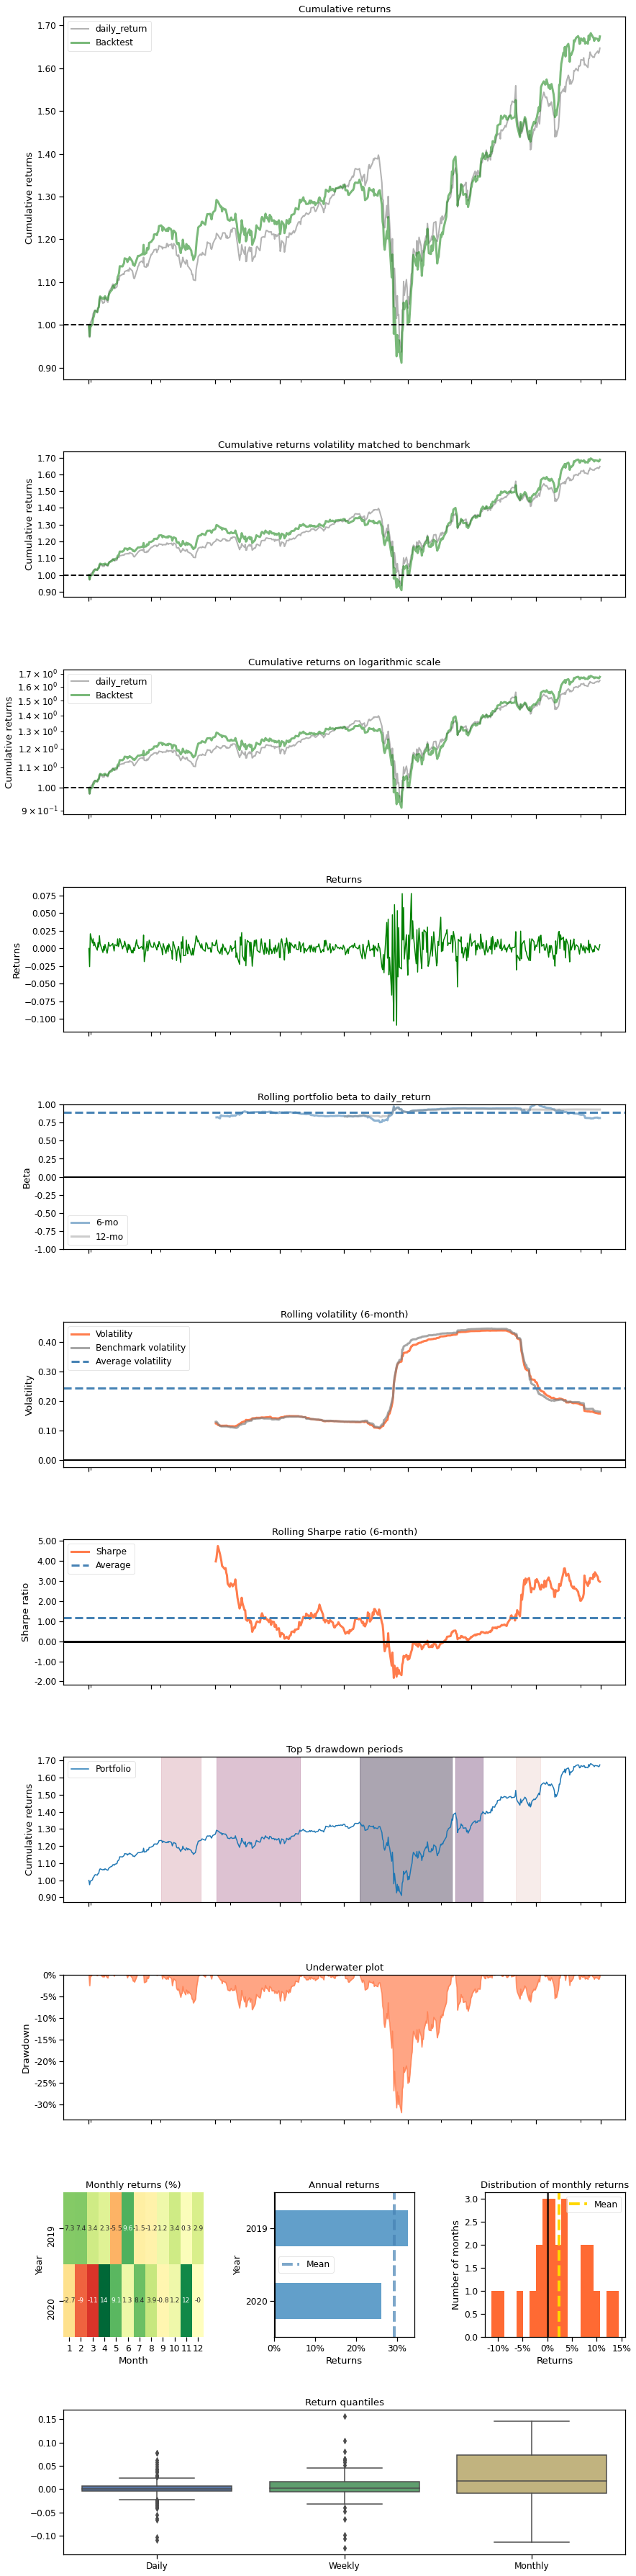

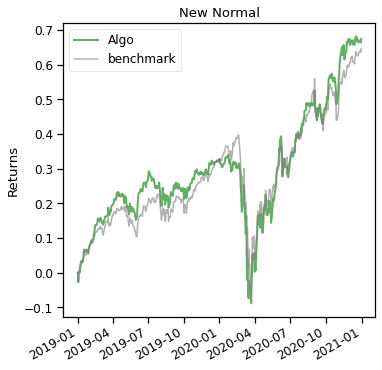

In [63]:
import pyfolio
%matplotlib inline

baseline_df = get_baseline(
        ticker='SUSA', start='2019-01-01', end='2021-01-01'
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)

In [64]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_ppo,
                        environment = e_trade_gym)

begin_total_asset:100000
end_total_asset:174993.27913499076
Sharpe:  1.2268046931069794
hit end!


In [65]:
df_daily_return

,date,daily_return
0,2019-01-02,0.000000
1,2019-01-03,-0.017468
2,2019-01-04,0.019196
3,2019-01-07,0.006513
4,2019-01-08,0.015267
...,...,...
500,2020-12-24,0.004965
501,2020-12-28,0.002686
502,2020-12-29,-0.001455
503,2020-12-30,0.000017


In [66]:
df_actions.head()

,EXPD,MTD,PEG,PEP,PPG,SPGI,TSCO,VTR,VZ,ZBRA
date,,,,,,,,,,
2019-01-02,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
2019-01-03,0.080075,0.080075,0.217665,0.080075,0.080075,0.080075,0.080075,0.141738,0.080075,0.080075
2019-01-04,0.072728,0.111588,0.132318,0.072728,0.100718,0.092133,0.072728,0.072728,0.197696,0.074633
2019-01-07,0.110701,0.125108,0.095524,0.095524,0.095524,0.095524,0.095524,0.095524,0.095524,0.095524
2019-01-08,0.067160,0.182560,0.067160,0.078927,0.067160,0.152994,0.067160,0.067160,0.067160,0.182560


In [67]:
df_actions.to_csv('df_actions_ppo_10_2.csv')

In [68]:
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

In [69]:
print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return           0.322118
Cumulative returns      0.749933
Annual volatility       0.254443
Sharpe ratio            1.226805
Calmar ratio            1.013241
Stability               0.584737
Max drawdown           -0.317908
Omega ratio             1.296581
Sortino ratio           1.695900
Skew                   -1.202333
Kurtosis               16.356318
Tail ratio              0.985604
Daily value at risk    -0.030818
Alpha                   0.000000
Beta                    1.000000
dtype: float64

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (506, 8)


Start date,2019-01-02
End date,2020-12-31
Total months,24
,Backtest
Annual return,32.212%
Cumulative returns,74.993%
Annual volatility,25.444%
Sharpe ratio,1.23
Calmar ratio,1.01
Stability,0.58
Max drawdown,-31.791%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,31.79,2020-01-23,2020-03-23,2020-06-03,95
1,8.37,2019-07-03,2019-08-05,2019-10-30,86
2,8.28,2020-06-08,2020-06-11,2020-07-15,28
3,6.53,2020-09-02,2020-09-23,2020-10-07,26
4,5.47,2020-10-12,2020-10-28,2020-11-05,19


Stress Events,mean,min,max
New Normal,0.12%,-12.42%,8.56%


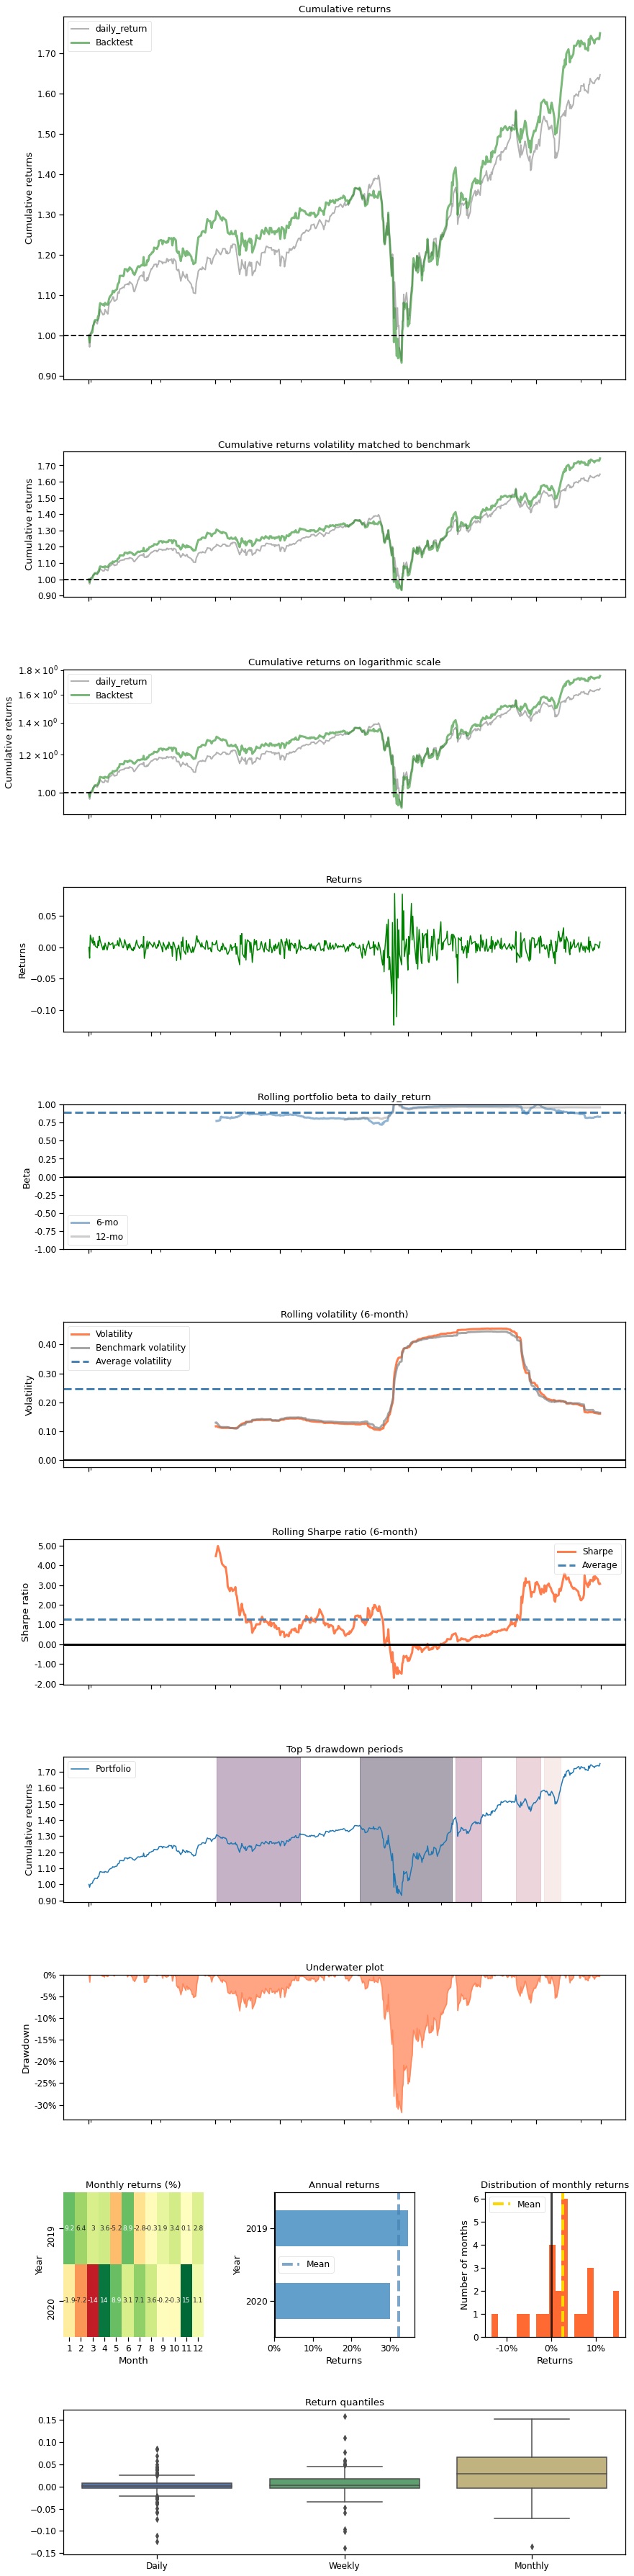

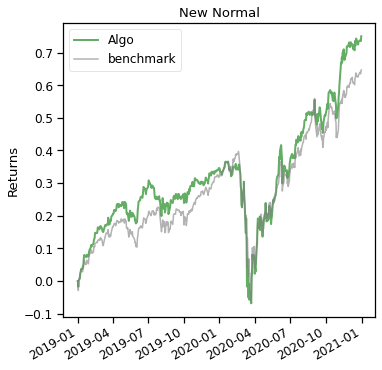

In [70]:
import pyfolio

%matplotlib inline

baseline_df = get_baseline(
        ticker='SUSA', start='2019-01-01', end='2021-01-01'
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)

In [71]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_sac,
                        environment = e_trade_gym)

begin_total_asset:100000
end_total_asset:157134.2860796522
Sharpe:  1.0429719757840905
hit end!


In [72]:
df_daily_return

,date,daily_return
0,2019-01-02,0.000000
1,2019-01-03,-0.023721
2,2019-01-04,0.021895
3,2019-01-07,0.005073
4,2019-01-08,0.013735
...,...,...
500,2020-12-24,0.004384
501,2020-12-28,0.001364
502,2020-12-29,-0.000490
503,2020-12-30,0.000053


In [73]:
df_actions

,EXPD,MTD,PEG,PEP,PPG,SPGI,TSCO,VTR,VZ,ZBRA
date,,,,,,,,,,
2019-01-02,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
2019-01-03,0.067264,0.129743,0.066035,0.093097,0.178006,0.085350,0.066572,0.071744,0.173708,0.068481
2019-01-04,0.066842,0.075365,0.066447,0.067360,0.179268,0.166368,0.066970,0.067639,0.176731,0.067010
2019-01-07,0.062508,0.108303,0.063475,0.153320,0.166146,0.084773,0.061789,0.064354,0.162576,0.072756
2019-01-08,0.066074,0.068684,0.066691,0.071561,0.177580,0.174320,0.066290,0.067192,0.173166,0.068442
...,...,...,...,...,...,...,...,...,...,...
2020-12-24,0.091686,0.090750,0.082631,0.066423,0.176802,0.117768,0.066421,0.067793,0.174027,0.065698
2020-12-28,0.058844,0.057490,0.070058,0.119316,0.149568,0.155689,0.059770,0.071918,0.154548,0.102798
2020-12-29,0.064892,0.124810,0.064231,0.061824,0.164670,0.162417,0.063656,0.062555,0.160187,0.070757


In [74]:
df_actions.to_csv('df_actions_sac_10_2.csv')

In [75]:
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

In [76]:
print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return           0.252971
Cumulative returns      0.571343
Annual volatility       0.245439
Sharpe ratio            1.042972
Calmar ratio            0.762393
Stability               0.498098
Max drawdown           -0.331812
Omega ratio             1.242109
Sortino ratio           1.441981
Skew                   -0.908314
Kurtosis               12.772000
Tail ratio              1.002205
Daily value at risk    -0.029907
Alpha                   0.000000
Beta                    1.000000
dtype: float64

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (506, 8)


Start date,2019-01-02
End date,2020-12-31
Total months,24
,Backtest
Annual return,25.297%
Cumulative returns,57.134%
Annual volatility,24.544%
Sharpe ratio,1.04
Calmar ratio,0.76
Stability,0.50
Max drawdown,-33.181%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,33.18,2020-01-16,2020-03-23,2020-07-17,132
1,6.17,2019-07-03,2019-08-05,2019-10-18,78
2,6.17,2020-09-02,2020-09-23,2020-10-08,27
3,6.15,2020-10-12,2020-10-28,2020-11-06,20
4,5.91,2019-04-15,2019-05-31,2019-06-10,41


Stress Events,mean,min,max
New Normal,0.10%,-10.97%,8.56%


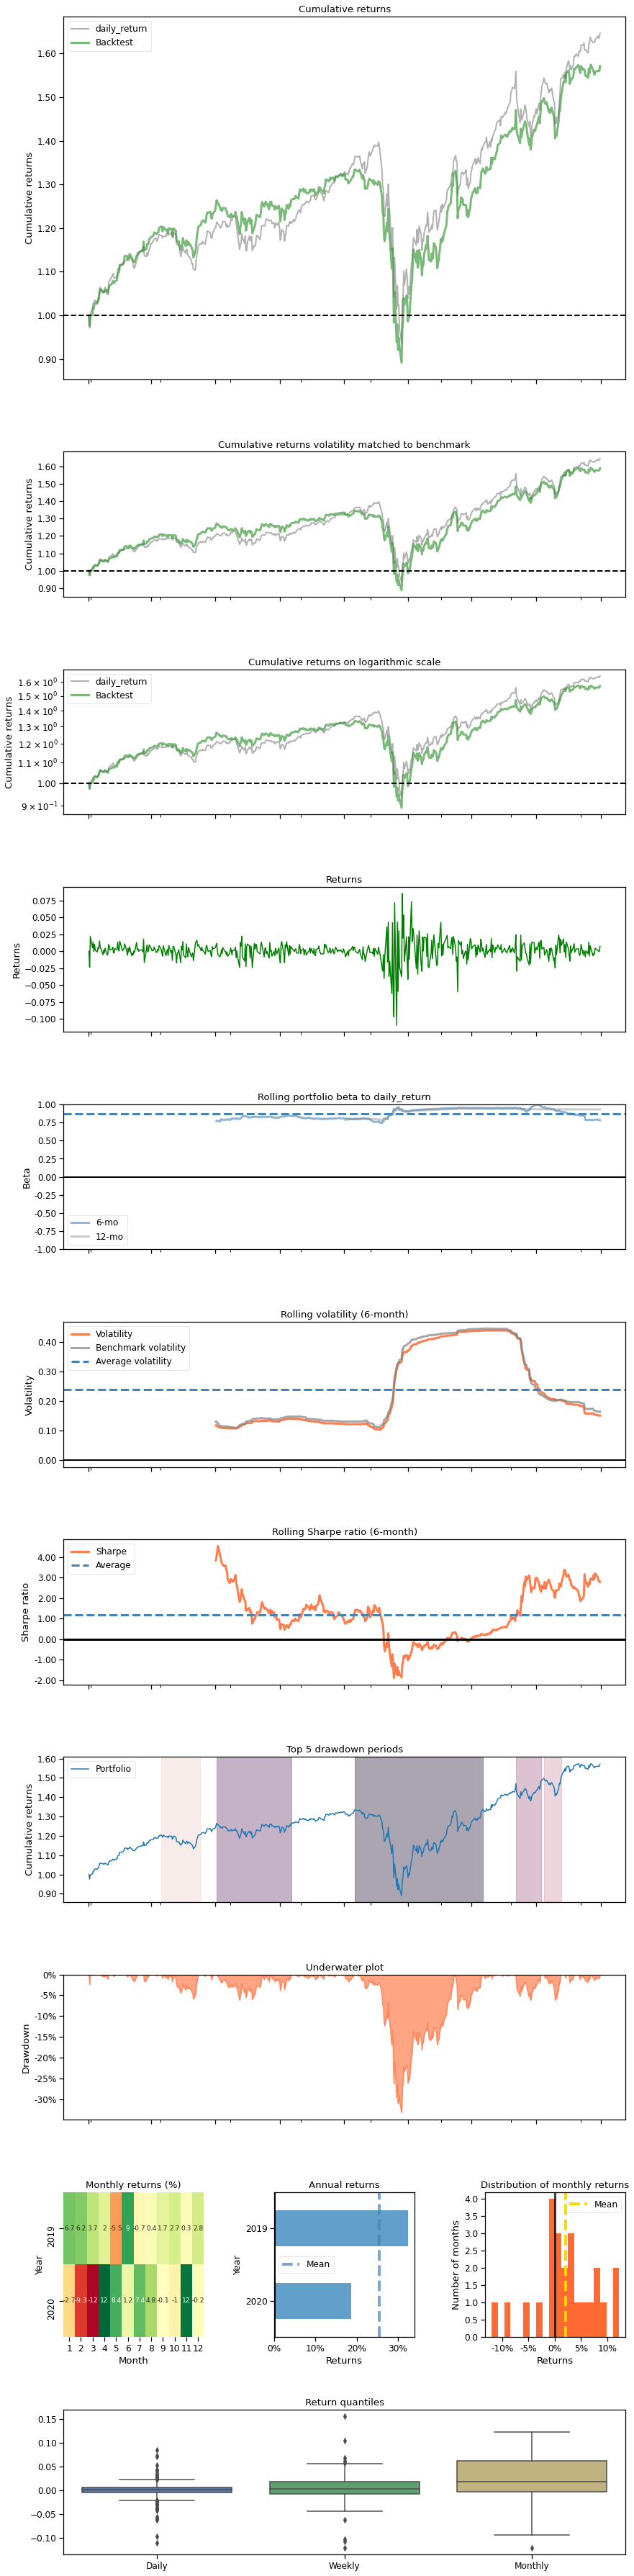

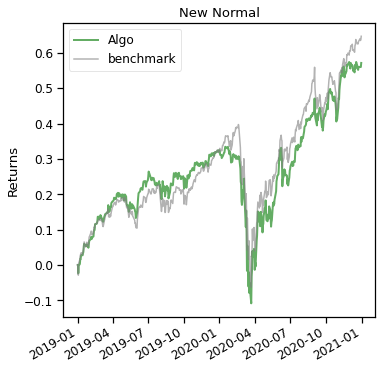

In [77]:
%matplotlib inline

baseline_df = get_baseline(
        ticker='SUSA', start='2019-01-01', end='2021-01-01'
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)